In [5]:
%load_ext autoreload  
%autoreload 2  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


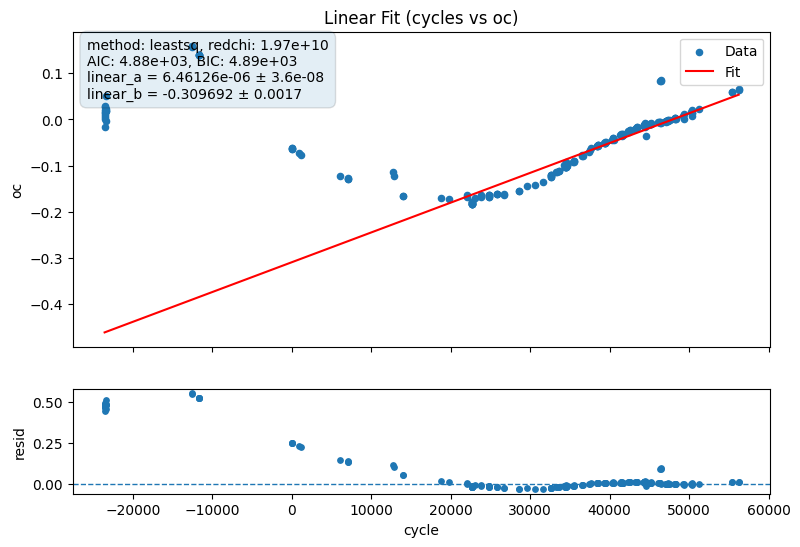

In [6]:
from ocpy.data import Data
from ocpy.oc import Linear, Parameter
# (OC_LMFit, OC ve diğerleri zaten ocpy içinde)

# 1) Veri → OC (cycles ve oc kolonları hazır)
data = Data.from_file("xy_boo.xlsx").fill_errors(0.03).calculate_weights()
oc = data.calculate_oc(reference_minimum=2439954.025, reference_period=0.370564)

# 2) Lineer model (y = a*x + b), başlangıç değerleri Parameter(dataclass)
lin = Linear(
    a = 0,
    b = 0
)

# 3) Fit ve çizim
res = oc.fit([lin])                 # ModelResult (veya None; sessiz mod)
print(res)
oc.fit_and_report(res, title="Linear Fit (cycles vs oc)")


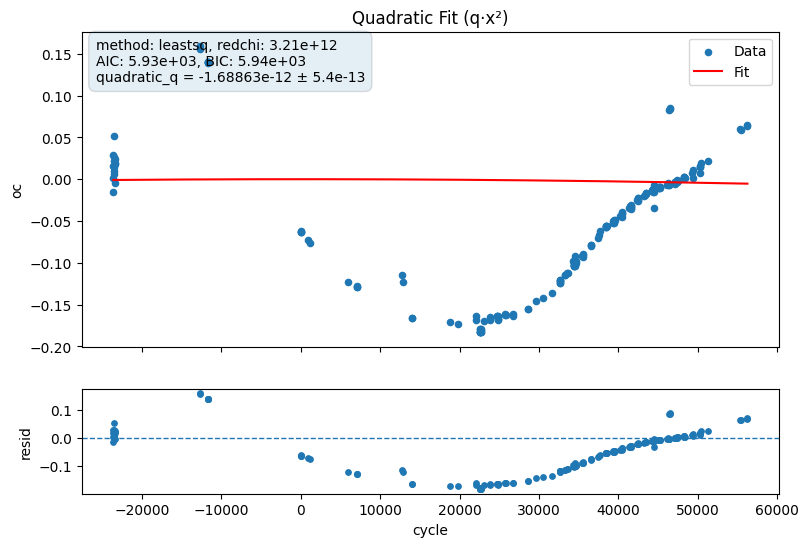

In [7]:
from ocpy.oc import Quadratic, Parameter

# y = q * (cycles)^2
quad = Quadratic(
    q = Parameter(value=-0, fixed=False),
)

res_q = oc.fit([quad])
oc.fit_and_report(res_q, title="Quadratic Fit (q·x²)")

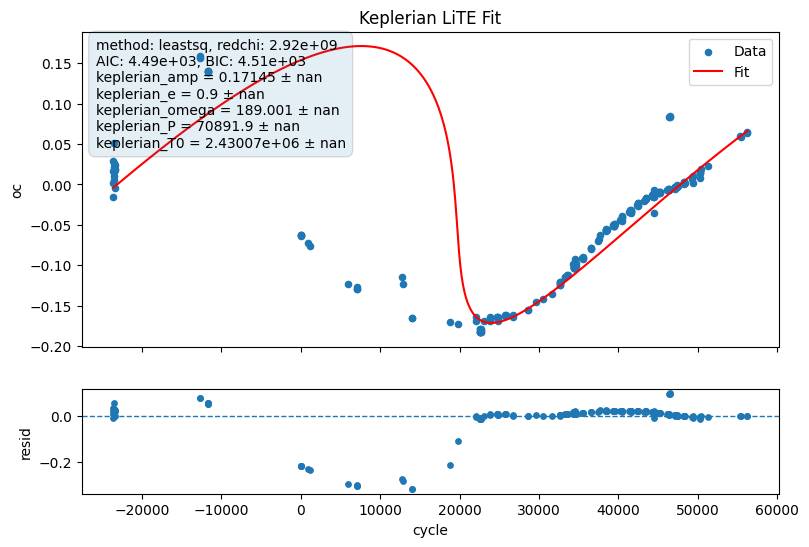

In [8]:
from ocpy.oc import Keplerian, Parameter
import numpy as np

# LiTE: Δt = K[(cosE - e)sinω + sqrt(1-e^2) sinE cosω], ω derece (model içinde rad'a çevriliyor)
kep = Keplerian(
    amp=   Parameter(value=1e-4, min=0.0),           # genelde küçük genlik
    e=     Parameter(value=0.1,  min=0.0, max=0.9),  # dışmerkezlik
    omega= Parameter(value=0.0),                     # derece
    P=     Parameter(value=70000.0, min=1.0),         # dönem (cycles biriminde)
    T0=    Parameter(value=float(np.nanmedian(oc.data["minimum_time"]))),  # başlangıç fazı için kaba tahmin
)

res_k = oc.fit([kep])
oc.fit_and_report(res_k, title="Keplerian LiTE Fit")

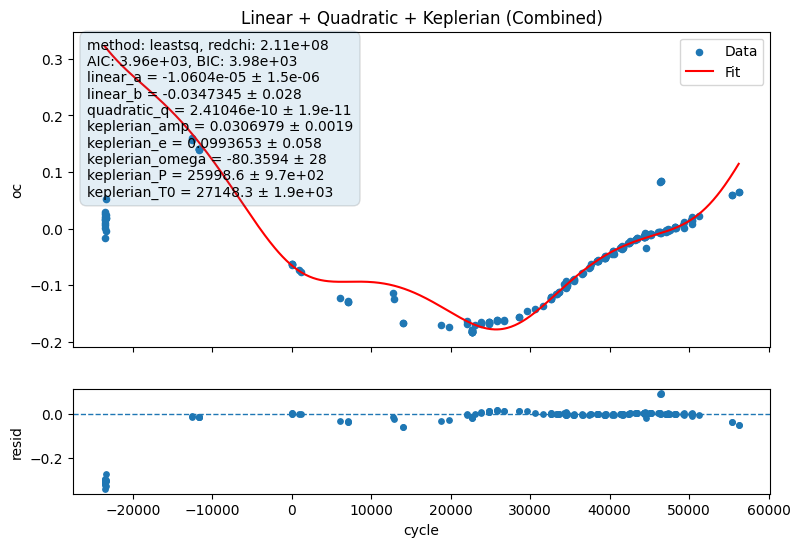

In [9]:
from ocpy.oc import Linear, Quadratic, Keplerian, Parameter
import numpy as np

dP_day   = -1.0507610376353504e-05     # -> Linear a
dT_day   =  0.0013192422196328115     # -> Linear b
Q_val    =  1.977678487279275e-10     # -> Quadratic q (x=epoch, y=day)

e_val       = 0.4504435851701752   # unitless
omega_deg   = 75.2639888267819   # deg
P_epoch     = 72033.78782038015   # epoch
T0_epoch    = 41147.51703595222 # epoch
K_day       = 0.06408717113781481   # amp in day -> K (no conversion needed)

# 3) Model bileşenleri (Parameter dataclass)
lin = Linear(
    a= Parameter(value=dP_day),
    b= Parameter(value=dT_day),
)
quad = Quadratic(
    q= Parameter(value=Q_val),
)
kep = Keplerian(
    amp=     Parameter(value=K_day, min=0.0),
    e=       Parameter(value=e_val,  min=0.0, max=0.99),
    omega=   Parameter(value=omega_deg),  # derece; model içinde rad'a çevriliyor
    P=       Parameter(value=P_epoch, min=1.0),
    T0=      Parameter(value=T0_epoch),
)

res_all = oc.fit([lin, quad, kep])
oc.fit_and_report(res_all, title="Linear + Quadratic + Keplerian (Combined)")

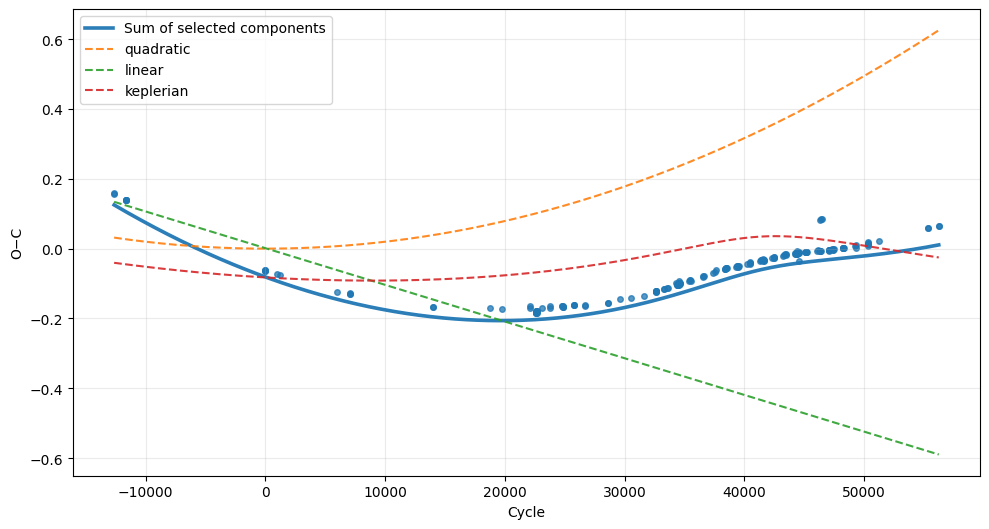

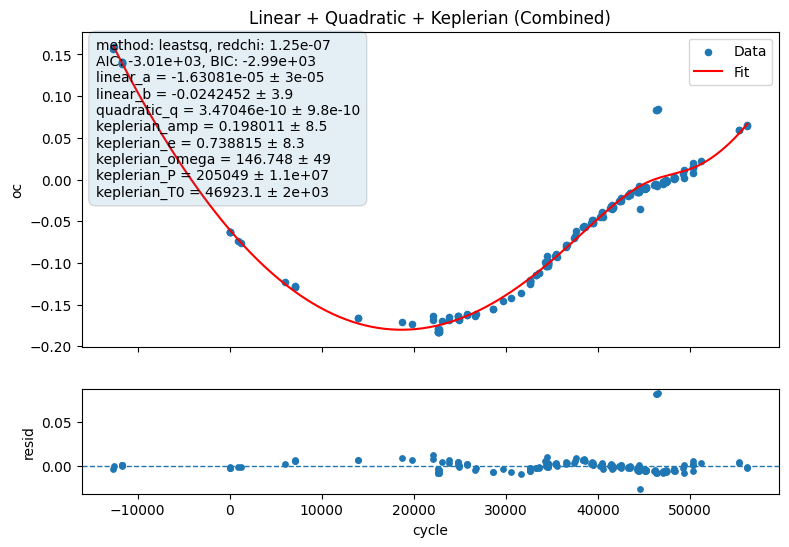

In [10]:
from ocpy.data import Data
from ocpy.oc import Linear, Quadratic, Keplerian, Parameter, KeplerianOld

# 1) Veri + OC (x=cycles, y=oc)
data = Data.from_file("xy_boo.xlsx").fill_errors(0.03).calculate_weights()
oc = data.calculate_oc(reference_minimum=2439954.025, reference_period=0.370564)  # OC_LMFit döner
oc = oc[oc["labels"] != "vis"]
oc["weights"] = .03

dP_day   = -1.0507610376353504e-05     # -> Linear a
dT_day   =  0.0013192422196328115     # -> Linear b
Q_val    =  1.977678487279275e-10     # -> Quadratic q (x=epoch, y=day)

e_val       = 0.4504435851701752   # unitless
omega_deg   = 75.2639888267819   # deg
P_epoch     = 72033.78782038015   # epoch
T0_epoch    = 41147.51703595222 # epoch
K_day       = 0.06408717113781481   # amp in day -> K (no conversion needed)

# 3) Model bileşenleri (Parameter dataclass)
lin = Linear(
    a= Parameter(value=dP_day),
    b= Parameter(value=dT_day),
)
quad = Quadratic(
    q= Parameter(value=Q_val),
)
kep = KeplerianOld(
    amp=     Parameter(value=K_day, min=0.0),
    e=     Parameter(value=e_val,  min=0.0, max=0.99),
    omega= Parameter(value=omega_deg),  # derece; model içinde rad'a çevriliyor
    P=   Parameter(value=P_epoch, min=1.0),
    T0=    Parameter(value=T0_epoch),
)

# 4A) Fit YAPMADAN: verilen parametrelerle eğri + residual
oc.plot_components_on_data([quad, lin, kep])
res_all = oc.fit([lin, quad, kep])
oc.fit_and_report(res_all, title="Linear + Quadratic + Keplerian (Combined)")

